## Exercice 1

In [1]:
import json 
import matplotlib.pyplot as plt
import urllib
import pandas as pd 
import numpy as np
import operator
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_curve, auc

In [2]:
# Reading training_set file 
with open('training_set.json', encoding="utf8") as json_file:
    training_data = json.load(json_file)
    
# Reading testing_set file 
with open('testing_set.json', encoding="utf8") as json_file:
    testing_data = json.load(json_file)

In [3]:
# Loading training data 
df_train = pd.read_json("training_set.json")

# Loading test data
df_test = pd.read_json("testing_set.json")

In [4]:
# Separating the feature (sentence) and the target (intent)
x_train = df_train['sentence'].to_numpy()
y_train = df_train['intent'].to_numpy()

x_test = df_test['sentence'].to_numpy()
y_test = df_test['intent'].to_numpy()

In [5]:
# Function that returns the sentence's intention (max probability)
def prediction(sentence) :
    url = "http://localhost:8080/api/intent?sentence=<" + urllib.parse.quote(sentence) +">"
    requete = urllib.request.urlopen(url)
    result_requete = json.load(requete)
    # Only focuses on the max index 
    prediction_result = max(result_requete.items(), key=operator.itemgetter(1))[0]
    return prediction_result

# Function that returns the probability of each class
def prediction_vect(sentence) :
    url = "http://localhost:8080/api/intent?sentence=<" + urllib.parse.quote(sentence) +">"
    requete = urllib.request.urlopen(url)
    result_requete = json.load(requete)
    # Only focuses on the max index 
    prediction_result = list(result_requete.values())
    return prediction_result

In [6]:
# Function that predicts intentions on all the test set and returns one intention
def predictionMaxProba(test_set) :
    y_prediction = []
    for i in range(len(test_set)):
        y_prediction.append(prediction(test_set[i]))
    return y_prediction 

# Prediction on test set (max probability)
y_prediction = predictionMaxProba(x_test)

# Function that predicts intentions on all the test set and returns each class's probability
def predictionProba(test_set) :
    y_prediction_vect = []
    for i in range(len(test_set)):
        y_prediction_vect.append(prediction_vect(test_set[i]))
    y_prediction_vect = np.array(y_prediction_vect)
    return y_prediction_vect

# Prediction on test set (probabilty of each class)
y_prediction_vect = predictionProba(x_test)

###  Analyse du jeu de données

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6035 entries, 0 to 6034
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    6035 non-null   object
 1   sentence  6035 non-null   object
dtypes: object(2)
memory usage: 94.4+ KB


In [8]:
df_train.describe()

,intent,sentence
count,6035,6035
unique,8,6035
top,irrelevant,T'es disponible 7/7 et 24/24 ?
freq,3852,1


In [9]:
df_train.groupby('intent').count()

,sentence
intent,
find-around-me,383
find-flight,142
find-hotel,316
find-restaurant,469
find-train,143
irrelevant,3852
provide-showtimes,117
purchase,613


#### Remarques : Les données d'entraînement ne semblent pas contenir de données nulles. Cette base est constituée de 8 classes et d'un total de 6035 données. La classe majoritaire est la classe 'irrelevant' et contient plus de 3800 données ce qui représente plus de la moitié de jeu de données d'entraînement. Le reste des classes contiennent très peu de données ce qui signifie un grand déséquilibre de ce jeu de données. On peut s'attendre à ce que cela influence les prédictions du modèle. 


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    1065 non-null   object
 1   sentence  1065 non-null   object
dtypes: object(2)
memory usage: 16.8+ KB


In [11]:
df_test.describe()

,intent,sentence
count,1065,1065
unique,8,1064
top,irrelevant,Est ce que tu connais des sites internet sur l...
freq,677,2


In [12]:
df_test.groupby('intent').count()

,sentence
intent,
find-around-me,67
find-flight,24
find-hotel,55
find-restaurant,93
find-train,21
irrelevant,677
provide-showtimes,14
purchase,114


#### Remarques : Le jeu de données de test contient 1065 données et ne contient pas non plus de données nulles. Tout comme pour le jeu d'entraînement, la classe 'irrelevant' est majoritaire et contient encore une fois plus de la moitié des données de test. Il faudra donc prêter attention aux métriques que l'on va utiliser pour évaluer les performances de ce modèle.

### Métriques de classification

In [13]:
# Comparison between y_prediction (prediction on x_test) and the actual results (y-test)
accuracy = accuracy_score(y_test, y_prediction)
print("Accuracy : " + str(accuracy))

Accuracy : 0.8093896713615023


##### Remarques :  A première vue, on pourrait penser que le modèle est plutôt fiable car il a une bonne justesse. Il faudrait cependant garder en tête que la base de données est fortement déséquilibrée.

In [14]:
balanced_accuracy = balanced_accuracy_score(y_test, y_prediction)
print("Balanced accuracy score : " + str(balanced_accuracy))

Balanced accuracy score : 0.5270967720223785


##### Remarques : La 'balanced accuracy score' calculera la justesse du modèle en prenant en considération le déséquilibre de la base de données sur laquelle il a été entraîné. On peut en conclure que le modèle sera bon pour reconnaître les données correspondantes à la classe 'irrelevant' qui est la classe majoritaire mais beaucoup moins bon pour reconnaître les autres classes.

In [15]:
print(classification_report(y_test, y_prediction))

                   precision    recall  f1-score   support

   find-around-me       0.86      0.37      0.52        67
      find-flight       0.88      0.29      0.44        24
       find-hotel       0.76      0.40      0.52        55
  find-restaurant       0.90      0.66      0.76        93
       find-train       0.93      0.67      0.78        21
       irrelevant       0.80      0.98      0.88       677
provide-showtimes       0.80      0.29      0.42        14
         purchase       0.82      0.56      0.67       114

         accuracy                           0.81      1065
        macro avg       0.84      0.53      0.62      1065
     weighted avg       0.82      0.81      0.79      1065



##### Remarques : On remarque qu'on a une précision qui est assez haute (et cela pour toutes les classes sauf la classe majoritaire 'irrelevant') tandis que le rappel est plutôt bas. Cela signifie que pour toutes les classes hormi la classe majoritaire, quand il s'agit en effet (par exemple) de la 'classe1' il n'est pas toujours capable de la classer en tant que 'classe1'. Mais quand il classe un élément dans la 'classe1', il s'agit en effet d'un élément de cette classe. 
##### Il n'y a que pour la classe 'irrelevant' que l'on voit une haute précision et un haut rappel, mais le rappel est supérieur à la précision. Cela signifie que le modèle classe plusieurs éléments comme étant 'irrelevant', qu'ils le soient ou non.

In [16]:
def plot_cm(y_true, y_pred, cmap, xticks_rotation, normalize):
    # Categories
    labels = ['find-around-me','find-flight','find-hotel', 'find-restaurant', 'find-train',  'irrelevant', 'provide-showtimes', 'purchase']
    # y_true and y_pred are OneHotEncoded, confusion_matrix takes a list of predictions !
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    if normalize == 'true': 
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            cm[i,j] = format(cm[i, j], '.2f')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap, ax=None, xticks_rotation='horizontal')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=12)
    plt.yticks(tick_marks, labels, fontsize=12)

C:\Users\hibsb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass include_values=viridis as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


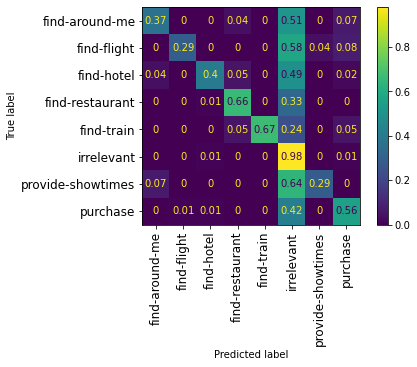

In [17]:
# Plot confusion matrix
plot_cm(y_test, y_prediction, 'viridis', 'horizontal', 'true')

##### Remarques : On peut déduire de cette matrice de confusion que le modèle classe la majorité des données comme étant 'irrelevant'. Lorsqu'il fait une prédiction, soit il prédit la bonne classe soit il prédit la classe majoritaire. Cela explique les résultats de rappel et précision obtenus précédemment. 

In [18]:
# ROC Score requires OneHotEncoded vector 
x = [['find-around-me'], ['find-flight'], ['find-hotel'], ['find-restaurant'], ['find-train'], ['irrelevant'], ['provide-showtimes'], ['purchase']]
encoder = OneHotEncoder().fit(x)
y_test_encoded = encoder.transform(y_test.reshape(-1,1)).toarray()

In [19]:
# ROC Score 
roc_auc_score(y_test_encoded, y_prediction_vect)

0.5688356888514263

##### Remarques : On a un ROC_AUC_Score plutôt bas, ce qui signifie que le modèle n'est pas capable de bien distinguer entre les classes.

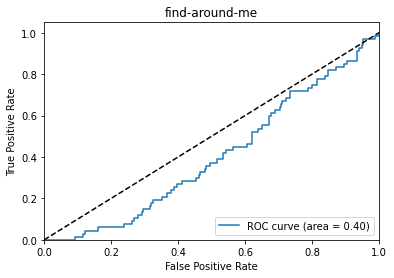

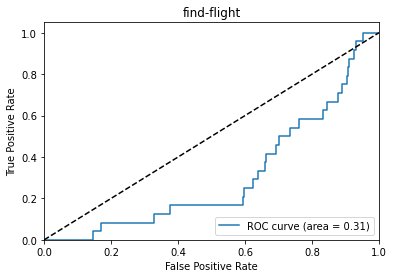

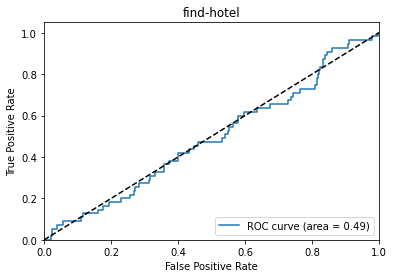

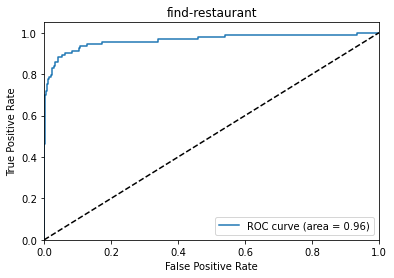

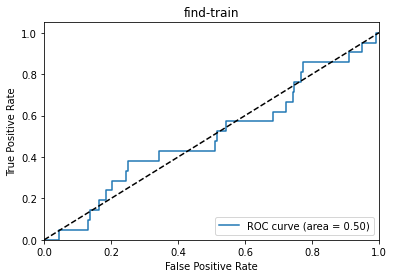

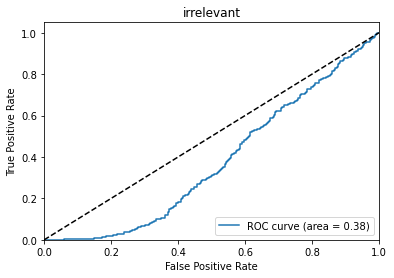

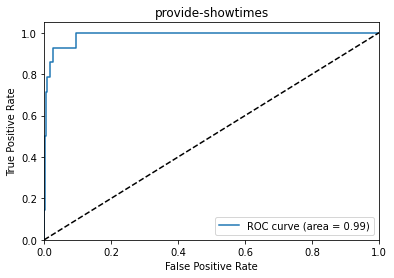

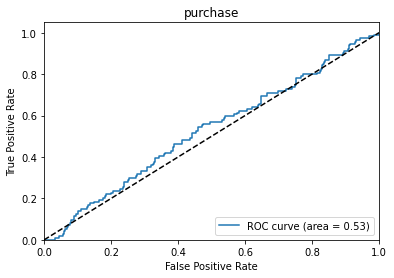

In [20]:
# Compute ROC curve for each class
n_classes = 8
fpr = [0 for i in range(n_classes)]
tpr = [0 for i in range(n_classes)]
roc_auc = [0 for i in range(n_classes)]
labels = ['find-around-me','find-flight','find-hotel', 'find-restaurant', 'find-train',  'irrelevant', 'provide-showtimes', 'purchase']
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_prediction_vect[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot of a ROC curve for all classes
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(labels[i]))
    plt.legend(loc="lower right")
    plt.show()

##### Remarques : 

## Exercice 2

##### Réponse / idées : 
Seuil de classification 
Voir comment est-ce qu'on fait pour déterminer cette valeur

## Exercice 3

##### Réponse / idées : 

## Exercice 4

##### Réponse / idées : 

## Exercice 5

##### Réponse / idées : 